In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker

In [2]:
import tools

In [3]:
data = pd.read_json("data/flink/commits_20220602-16h05m47s_apache_flink_master_commits.txt", lines=True)
tools.initialize_datetime(data)
data = data.sort_values(by='authoredDate')
data['_count'] = 1

In [4]:
competitors = ['spark', 'beam', 'kafka']
datasets = []
for competitor in competitors:
    dataset = pd.read_json(f"data/{competitor}_commits.txt", lines=True)
    tools.initialize_datetime(dataset)
    dataset['_count'] = 1
    datasets.append(dataset)

## Overall

We first discuss the projects in terms of size. What is the size of a project? Developers know that the number of code lines is not a good measure for the popularity of a project. Instead we use the number of commits. Although commits may vary greatly in importance, every commit is in principle a fundamental work unit. We also want to know the number of people that work on the project. Here, we need to differentiate between authors (developers creating pull requests) and committers (developers authorized to merge pull requests). We are also interested in the author-to-committer ratio. A healthy project should not ask their committers to manage too many authors.

In [5]:
def get_number_of_author(dataset):
    return dataset['authorDatabaseId'].drop_duplicates().count()

def get_number_of_committer(dataset):
    return dataset['committerDatabaseId'].drop_duplicates().count()

def get_number_commits(dataset: pd.DataFrame):
    return dataset.shape[0]

In [6]:
number_of_authors = [get_number_of_author(data)] + [get_number_of_author(dataset) for dataset in datasets]
number_of_committer = [get_number_of_committer(data)] + [get_number_of_committer(dataset) for dataset in datasets]
number_of_commits = [get_number_commits(data)] + [get_number_commits(dataset) for dataset in datasets]
overall = pd.DataFrame({'number_of_authors': number_of_authors, 'number_of_committer': number_of_committer, 'number_of_commits': number_of_commits},
            index=['Flink'] + competitors)
overall['author_to_committer_ratio'] = overall['number_of_authors'] / overall['number_of_committer']

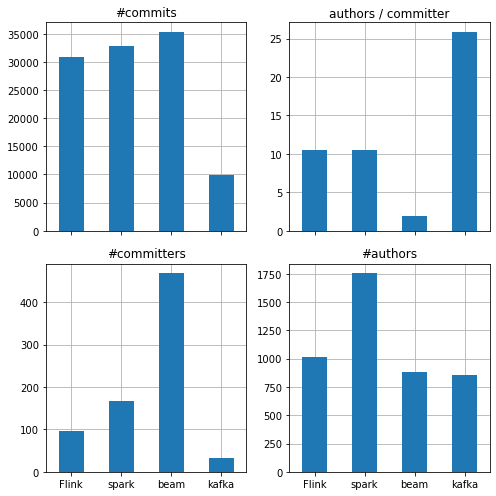

In [7]:
f, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(7, 7))
axes = axes.flatten()

def plot_total_number_of_commits(ax):
    overall[['number_of_commits']].plot.bar(ax=ax, legend=False)
    ax.set_title('#commits')

def plot_total_number_of_authors(ax):
    overall[['number_of_authors']].plot.bar(ax=ax, legend=False)
    ax.set_title('#authors')

def plot_total_number_of_committers(ax):
    overall[['number_of_committer']].plot.bar(ax=ax, legend=False)
    ax.set_title('#committers')

def plot_total_ratio_authors_to_committers(ax):
    overall[['author_to_committer_ratio']].plot.bar(ax=ax, legend=False)
    ax.set_title('authors / committer')


plot_total_number_of_commits(axes[0])
plot_total_ratio_authors_to_committers(axes[1])
plot_total_number_of_committers(axes[2])
plot_total_number_of_authors(axes[3])

for ax in axes:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

tools.savefig(f, "commits_total_statistics")

Let’s first look at the overall number of commits. We see that Flink, Spark and Beam have a similar number of commits (30k-36k). In contrast, Kafka only has about a third of the commits (10k). If we take commits as a unit of work, then Kafka has received about a third of the work of the other projects. The number of authors for Spark is almost twice as great (\~1.8k) as for all projects (\~1k). Combined with the number of commits, we find that Spark’s and Kafka’s authors are less productive than the authors of Beam and Flink. The author-to-committer ratio for Flink and Spark is 11:1, while Kafka has a 26:1 ratio. Beam has a 2:1 ratio. Here we have to stop and ask: “What is the right ratio of authors to committers?”. A committer has the task of merging the PRs of authors and is the final human filter for any code. A high ratio indicates that committers will be overwhelmed with PRs. If the ratio is too low, then committers may have diverging opinions about the feature set and coding standards can be adverse to the code base. The right number depends on the processes and tools in place that ensure uniform decision making and ease the workload of committers. 


In [8]:
def contributors_over_time_new(dataset):
    return dataset.set_index('committedDate')[['authorDatabaseId', '_count']].sort_index().dropna().drop_duplicates().drop(columns=['authorDatabaseId'])['_count']

def contributors_over_time_cumul(dataset):
    return contributors_over_time_new(dataset).cumsum()

def contributors_new_per_month(dataset):
    return contributors_over_time_new(dataset).resample('M').sum().rolling(6).mean()

def committers_over_time_new(dataset):
    return dataset.set_index('committedDate')[['committerDatabaseId', '_count']].sort_index().dropna().drop_duplicates().drop(columns=['committerDatabaseId'])['_count']

def committers_over_time_cumul(dataset):
    return committers_over_time_new(dataset).cumsum()

def committers_new_per_month(dataset):
    return committers_over_time_new(dataset).resample('M').sum().rolling(6).mean()

def contributions_over_time_new(dataset):
    return dataset.set_index('committedDate')[['_count']].sort_index()['_count']

def contributions_over_time_cumul(dataset):
    return contributions_over_time_new(dataset).cumsum()

def contributions_new_per_month(dataset):
    return contributions_over_time_new(dataset).resample('M').sum().rolling(6).mean()

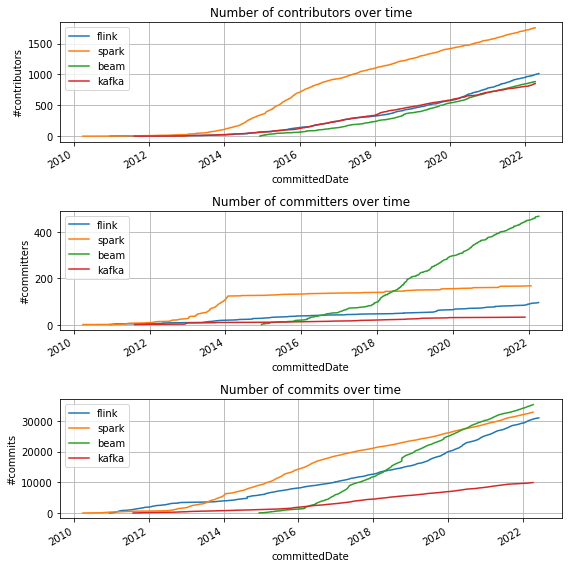

In [9]:
f, axes = plt.subplots(nrows=3, sharex=False, figsize=(8, 8))

def plot_contributors_over_time_cumul(ax):
    contributors_over_time_cumul(data).plot(ax=ax, label='flink')
    for competitor, dataset in zip(competitors, datasets):
        contributors_over_time_cumul(dataset).plot(ax=ax, label=competitor)
    ax.legend()
    ax.grid(which='both')
    ax.set(ylabel='#contributors')
    ax.set_title('Number of contributors over time')

def plot_committers_over_time_cumul(ax):
    committers_over_time_cumul(data).plot(ax=ax, label='flink')
    for competitor, dataset in zip(competitors, datasets):
        committers_over_time_cumul(dataset).plot(ax=ax, label=competitor)
    ax.legend()
    ax.grid(which='both')
    ax.set(ylabel='#committers')
    ax.set_title('Number of committers over time')
    
def plot_contributions_over_time_cumul(ax):
    contributions_over_time_cumul(data).plot(ax=ax, label='flink')
    for competitor, dataset in zip(competitors, datasets):
        contributions_over_time_cumul(dataset).plot(ax=ax, label=competitor)
    ax.legend()
    ax.grid(which='both')
    ax.set(ylabel='#commits')
    ax.set_title('Number of commits over time')

plot_contributors_over_time_cumul(axes[0])
plot_committers_over_time_cumul(axes[1])
plot_contributions_over_time_cumul(axes[2])

tools.savefig(f, "commits_total_statistics_over_time")

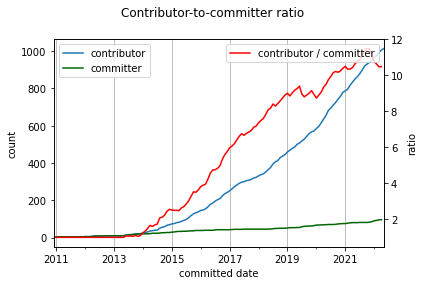

In [10]:
contributor = data.set_index('committedDate')[['authorLogin', '_count']].drop_duplicates().dropna().drop(columns=['authorLogin']).groupby(pd.Grouper(freq='M')).sum().cumsum()['_count']
committer = data.set_index('committedDate')[['committerLogin', '_count']].drop_duplicates().dropna().drop(columns=['committerLogin']).groupby(pd.Grouper(freq='M')).sum().cumsum()['_count']
f, ax = plt.subplots()
contributor.plot(ax=ax, label='contributor')
committer.plot(ax=ax, label='committer', color='darkgreen')
ax.legend()
ax2 = ax.twinx()
(contributor / committer).plot(ax=ax2, color='red', label='contributor / committer')
ax2.legend(loc='upper right')
ax.grid(axis='x')
ax.set(xlabel='committed date', ylabel='count')
ax2.set(ylabel='ratio')
f.suptitle('Contributor-to-committer ratio')
tools.savefig(f, 'commits_contributor_to_committer')

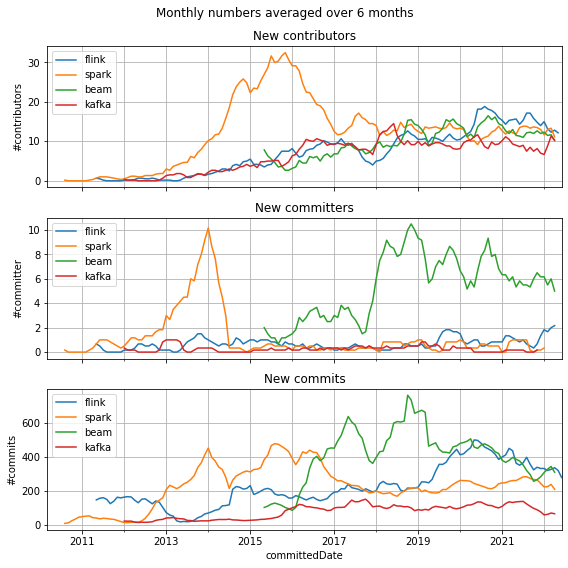

In [11]:
f, axes = plt.subplots(nrows=3, sharex=True, figsize=(8, 8))

def plot_contributors_new_per_month(ax):
    contributors_new_per_month(data).plot(ax=ax, label='flink')
    for competitor, dataset in zip(competitors, datasets):
        contributors_new_per_month(dataset).plot(ax=ax, label=competitor)
    ax.legend()
    ax.grid(which='both')
    ax.set(ylabel='#contributors')
    ax.set_title('New contributors')

def plot_committers_new_per_month(ax):
    committers_new_per_month(data).plot(ax=ax, label='flink')
    for competitor, dataset in zip(competitors, datasets):
        committers_new_per_month(dataset).plot(ax=ax, label=competitor)
    ax.legend()
    ax.grid(which='both')
    ax.set(ylabel='#committer')
    ax.set_title('New committers')
    
def plot_contributions_new_per_month(ax):
    contributions_new_per_month(data).plot(ax=ax, label='flink')
    for competitor, dataset in zip(competitors, datasets):
        contributions_new_per_month(dataset).plot(ax=ax, label=competitor)
    ax.legend()
    ax.grid(which='both')
    ax.set(ylabel='#commits')
    ax.set_title('New commits')

plot_contributors_new_per_month(axes[0])
plot_committers_new_per_month(axes[1])
plot_contributions_new_per_month(axes[2])

f.suptitle('Monthly numbers averaged over 6 months')
tools.savefig(f, "commits_monthly_statistics")

Let’s now look at the same metrics over time to understand the current development of the projects. First, we see that the number of new contributors has converged lately to about 10 per month. Second, for the number of new committers we see that Beam is growing at a faster pace  than the other projects with about 6 per month. With about 1-2 committers per month Flink is growing a bit stronger than Spark and Kafka with at most 1 committer per month. Looking at the number of commits, we see that Flink and Beam are the most active projects with about 300 commits per month in the last two years. Spark is slightly less active with about 200 commits per month followed by Kafka with around 100 commits per month. Important points:
Spark had a very active phase between 2013 and 2017 but has slowed down in recent years.
Kafka has been less active over the years which could be related to the small number of committers.
Beam has seen impressive growth between 2016 and 2020. More impressive still is how the project is able to transform so many contributors into committers.
Flink has not seen the same growth spikes as Beam or Spark, but it is the most steadily growing project of the four and (apart from committers) has been the most active in 2021.

## Active contributors

In [12]:
def active_contributors(dataset: pd.DataFrame):
    return dataset.set_index('authoredDate')['authorDatabaseId'].dropna().resample('M').apply(lambda x: x.nunique()).rolling(6).mean()

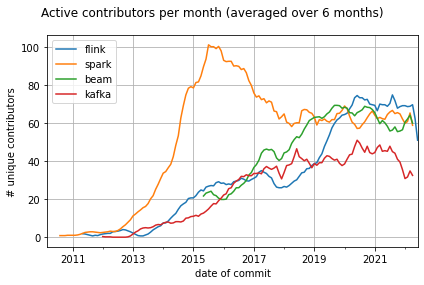

In [13]:
f, ax = plt.subplots()
active_contributors(data).plot(ax=ax, label='flink')
for competitor, dataset in zip(competitors, datasets):
    active_contributors(dataset).plot(ax=ax, label=competitor)
ax.grid()
ax.legend()
ax.set(xlabel='date of commit', ylabel='# unique contributors')
f.suptitle('Active contributors per month (averaged over 6 months)')
tools.savefig(f, "commits_monthly_active_contributors")

Another statistic we can look at is the number of active contributors every month. This are all contributors that have contributed a commit in the month. Here we find that Spark, Flink and Beam converge to the same number of about 60 contributors per month. Kafka is around 40. 

## CDFs

In [14]:
def cdf_counts(dataset: pd.DataFrame, column: str) -> pd.Series:
    count = dataset[column].value_counts().value_counts().sort_index()
    perc = count / count.sum() * 100
    return perc.cumsum()

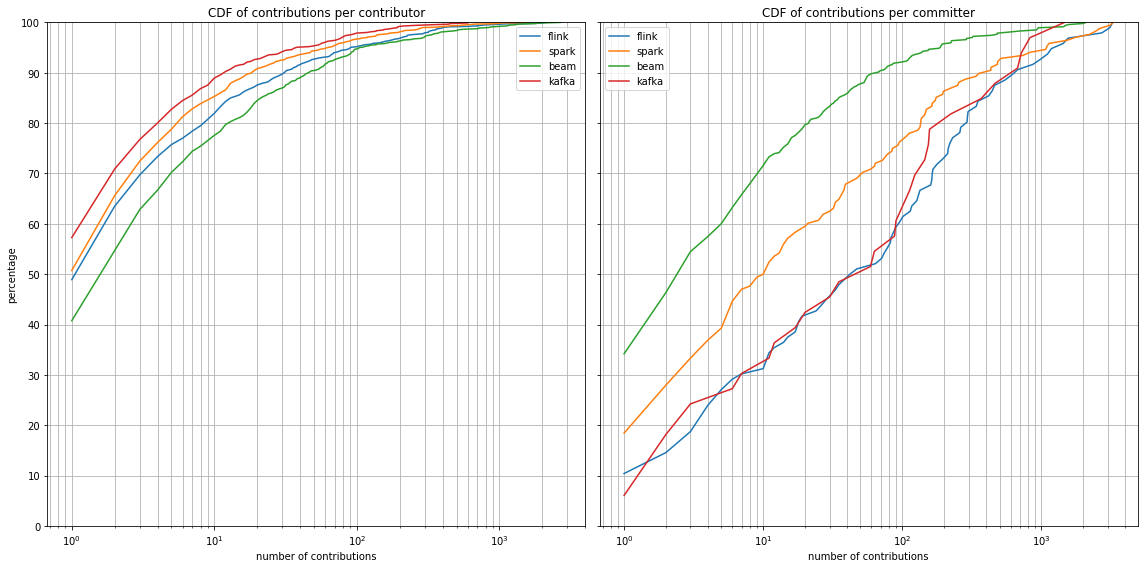

In [15]:
f, axes = plt.subplots(figsize=(16, 8), ncols=2, sharey=True)

def plot_cdf_contributions_per_contributor(ax):
    cdf_counts(data, 'authorDatabaseId').plot(ax=ax, label='flink')
    for competitor, dataset in zip(competitors, datasets):
        cdf_counts(dataset, 'authorDatabaseId').plot(ax=ax, label=competitor)
    ax.legend()
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax.set(xscale='log', xlabel='number of contributions', ylabel='percentage', ylim=(0, 100))
    ax.grid(which='both')
    ax.set_title('CDF of contributions per contributor')

def plot_cdf_contributions_per_committer(ax):
    cdf_counts(data, 'committerDatabaseId').plot(ax=ax, label='flink')
    for competitor, dataset in zip(competitors, datasets):
        cdf_counts(dataset, 'committerDatabaseId').plot(ax=ax, label=competitor)
    ax.legend()
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax.set(xscale='log', xlabel='number of contributions', ylabel='percentage', ylim=(0, 100))
    ax.grid(which='both')
    ax.set_title('CDF of contributions per committer')
    
plot_cdf_contributions_per_contributor(axes[0])
plot_cdf_contributions_per_committer(axes[1])
tools.savefig(f, "commits_cdf_contributions")